In [1]:
!nvidia-smi

Fri Aug 30 13:01:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
|  0%   40C    P8              31W / 450W |    457MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
#!pip3 freeze > requirements.txt

In [5]:
import tensorflow as tf

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-30 16:44:32.504337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 16:44:32.651016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 16:44:32.651181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
torch.cuda.is_available() # Do we have a GPU? Should return True.

True

In [8]:
torch.cuda.device_count()  # How many GPUs do we have access to?

1

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Check which device we got

cuda:0


In [10]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [12]:
X_train = torch.IntTensor([0, 30, 50, 75, 70])  # Initialize a Tensor of Integers with no device specified
print(X_train.is_cuda, ",", X_train.device)  # Check which device Tensor is created on

False , cpu


In [13]:
# Move the Tensor to the device we want to use
X_train = X_train.cuda()
# Alternative method: specify the device using the variable
# X_train = X_train.to(device)
# Confirm that the Tensor is on the GPU now
print(X_train.is_cuda, ",", X_train.device)

True , cuda:0


In [14]:
# Alternative method: Initialize the Tensor directly on a specific device.
X_test = torch.cuda.IntTensor([30, 40, 50], device=device)
print(X_test.is_cuda, ",", X_test.device)

True , cuda:0


/tmp/ipykernel_22268/1280660427.py:2: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  X_test = torch.cuda.IntTensor([30, 40, 50], device=device)


In [15]:
# Here is a basic fully connected neural network built in Torch.
# If we want to load it / train it on our GPU, we must first put it on the GPU
# Otherwise it will remain on CPU by default.

batch_size = 100

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 784)
        self.fc2 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [16]:
model = SimpleNet().to(device)  # Load the neural network model onto the GPU

In [17]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""
# Transform our data into Tensors to normalize the data
train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

# Set up a training data set
trainset = datasets.FashionMNIST('./data', train=True, download=True,
                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Set up a test data set
testset = datasets.FashionMNIST('./data', train=False,
                  transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:11<00:00, 2267661.72it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 154270.38it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 2897236.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 20882279.49it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



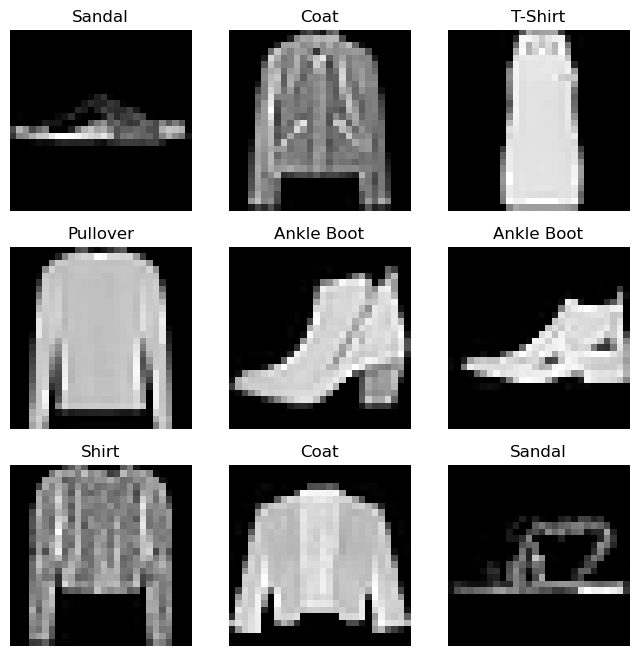

In [18]:
# A dictionary to map our class numbers to their items.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plotting 9 random different items from the training data set, trainset.
figure = plt.figure(figsize=(8, 8))
for i in range(1, 3 * 3 + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.view(28,28), cmap="gray")
plt.show()

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    """Model training function"""
    model.train()
    print(device)
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [20]:
def test(model, device, test_loader):
    """Model evaluating function"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # Use the no_grad method to increase computation speed
    # since computing the gradient is not necessary in this step.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
# number of  training 'epochs'
EPOCHS = 5
# our optimization strategy used in training.
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

In [24]:
for epoch in range(1, EPOCHS + 1):
        print( f"EPOCH: {epoch}")
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

EPOCH: 1
cuda:0


600it [00:04, 126.49it/s]



Test set: Average loss: -0.5824, Accuracy: 6648/10000 (66%)

EPOCH: 2
cuda:0


600it [00:03, 154.27it/s]



Test set: Average loss: -0.6643, Accuracy: 7330/10000 (73%)

EPOCH: 3
cuda:0


600it [00:03, 154.00it/s]



Test set: Average loss: -0.7092, Accuracy: 7571/10000 (76%)

EPOCH: 4
cuda:0


600it [00:04, 149.53it/s]



Test set: Average loss: -0.7302, Accuracy: 7679/10000 (77%)

EPOCH: 5
cuda:0


600it [00:04, 135.64it/s]



Test set: Average loss: -0.7426, Accuracy: 7745/10000 (77%)



In [25]:
# Saving the model's weights!
torch.save(model.state_dict(), "mnist_fashion_SimpleNet.pt")